# Remote smart STEM with AutoScript: Tutorial for Arems 2025 
- Contributors:
    - Gerd Duscher
    - Utkarsh Pratiush
    - Austin Houston

- Outline:
    - Connect to the microscope server
    - Get HAADF image
    - Find particles using segmentation:
        - selct 10 particles with highest area
            - Get edx
            - do current caliberation using gun lens
            - Get edx at higher current
            - Get diffraction






## 1a. import and set paths 

In [1]:
from stemOrchestrator.logging_config   import setup_logging
data_folder  = "."
out_path = data_folder
setup_logging(out_path=out_path) 

In [2]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging
plot = plt
from typing import Dict

## 1b. Connect to the Microscope server

In [8]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if ip is None:
    print("please check path of yaml file containing ip and port info")

else:
    print("your yaml file with ip and port loaded fine")
config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 40e-8,  # micro-seconds per pixel
    "haadf_resolution": 512, # square
    "out_path": "."
}

your yaml file with ip and port loaded fine


In [9]:

ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]



microscope = TemMicroscopeClient()
microscope.connect(ip, port = port)# 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])


Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-10-08 11:48:07,636 - INFO - Starting microscope initialization...
2025-10-08 11:48:07,657 - INFO - CETA camera initialized
2025-10-08 11:48:07,663 - INFO - HAADF detector initialized
2025-10-08 11:48:07,671 - INFO - Microscope initialization completed successfully


## 1c. Get HAADF image

2025-10-08 11:48:13,263 - INFO - Acquiring HAADF image.
2025-10-08 11:48:13,266 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-08 11:48:13,390 - INFO - DONE -- beam UNblanking
2025-10-08 11:48:13,878 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:48:13,896 - INFO - DONE -- beam blanking
2025-10-08 11:48:14,976 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-10-08 11:48:14,978 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


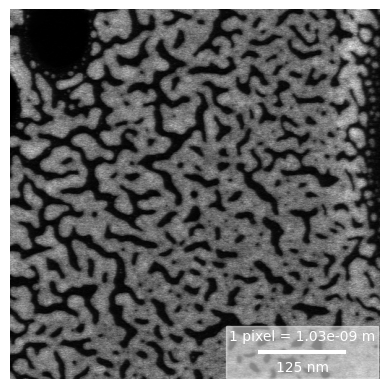

In [10]:
# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(exposure = haadf_exposure, resolution=haadf_resolution)

HAADF_tiff_to_png(haadf_tiff_name)

## 1d. Find particles using segmentation

In [11]:
########SAM part ********************************************************************************************************
#-----> takes quite some time to load -- 
from stemOrchestrator.MLlayer.MLlayerSAM import setup_device, download_sam_model, initialize_sam_model, preprocess_image, generate_and_save_masks, create_normalized_particle_positions, display_image_with_masks, display_image_with_labels, extract_mask_contours, generate_mask_colors, visualize_masks_with_boundaries, extract_particle_data, print_boundary_points_info, plot_centroids, sample_particle_positions, plot_sampled_positions, create_visualization_with_masks
import pickle
import numpy as np
from typing import List, Dict, Union


def run_sam(image_data: np.ndarray, path_folder: str) -> Union[List, Dict]:
    """Main function to run SAM segmentation pipeline."""
    device = setup_device()
    
    model_type = "vit_b"  # Options: 'vit_b', 'vit_l', 'vit_h'
    checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    checkpoint_path = "sam_vit_b_01ec64.pth"
    download_sam_model(model_type, checkpoint_url, checkpoint_path)
    sam, mask_generator = initialize_sam_model(model_type, checkpoint_path, device)
    img_np = preprocess_image(image_data)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Generate and visualize masks
    masks_path = f'{path_folder}/masks_Au_online.pkl'
    masks = generate_and_save_masks(mask_generator, img_np, masks_path)
    visual_image, centroids = create_visualization_with_masks(img_np, masks)
    display_image_with_masks(visual_image, "Image with Segmentation Masks")
    display_image_with_labels(visual_image, centroids, "Image with Segmentation Masks and Labels")
    
    mask_contours = extract_mask_contours(masks)
    mask_colors = generate_mask_colors(len(masks))
    boundaries_path = f"{path_folder}/Segmentation Masks with Boundaries and Centroids.png"
    visualize_masks_with_boundaries(visual_image, centroids, mask_contours, mask_colors, boundaries_path)
    particles = extract_particle_data(masks)
    # Save particle data
    # with open(f'{path_folder}/particles.pkl', 'wb') as f:
    #     pickle.dump(particles, f)
    
    print_boundary_points_info(particles)
    centroids_array = np.array(centroids)
    plot_centroids(centroids_array, img_np)
    positions_sampled = sample_particle_positions(particles, img_np)
    plot_sampled_positions(positions_sampled, img_np, len(centroids))
    each_particle_position = create_normalized_particle_positions(particles, img_np.shape[:2])
    # with open(f'{path_folder}/sampled_boundary_pts_particles.pkl', 'wb') as f: # Save normalized particle positions
    #     pickle.dump(each_particle_position, f)
    
    all_particle_keys = each_particle_position.keys()


    
    print("Processing complete!")
    return all_particle_keys, each_particle_position

##########****************************************************************************************************************************


20251008_115116
Using device: cuda
Download complete.


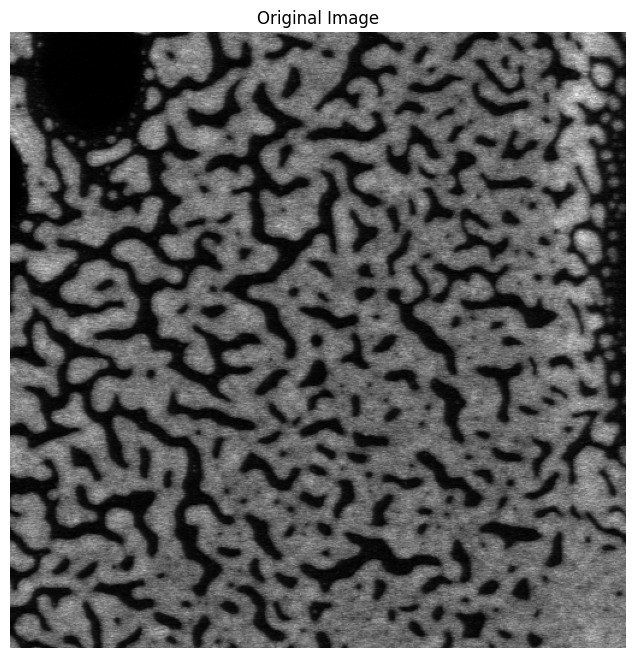

Generating masks...
Number of masks generated: 140
2025-10-08 11:52:21,942 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..324.79803].


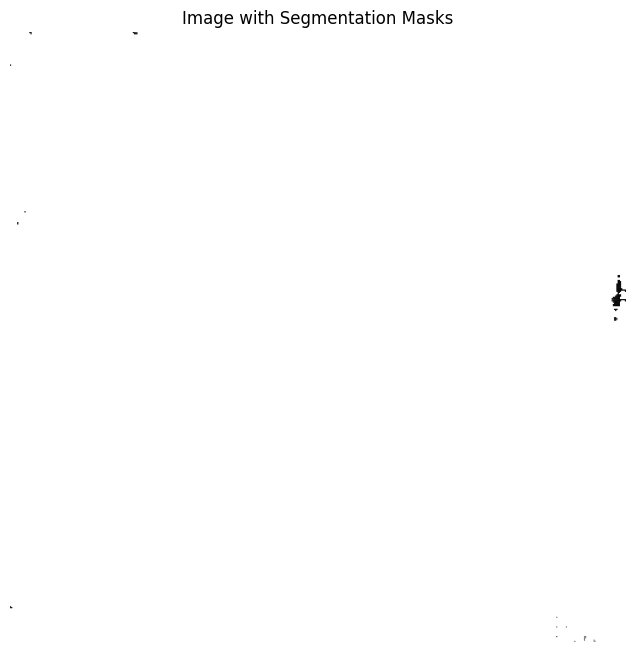

2025-10-08 11:52:22,072 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..324.79803].


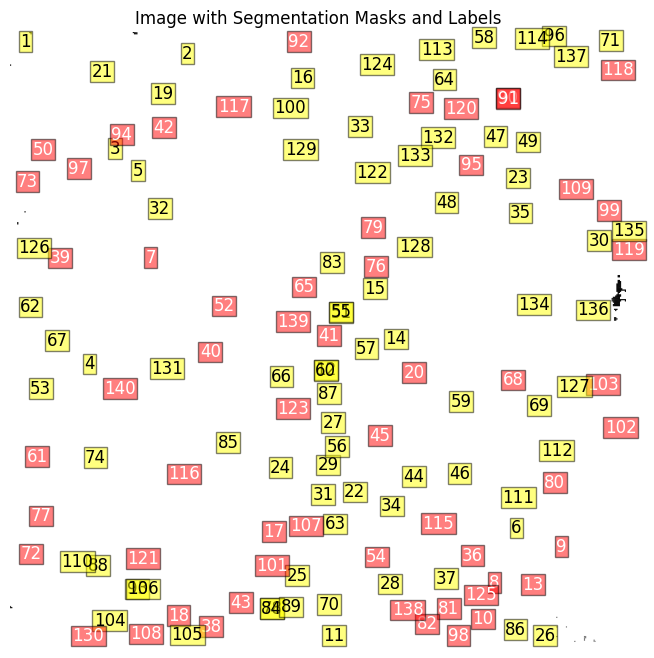

Extracted contours for 140 masks.
2025-10-08 11:52:23,361 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764706..324.79803].
Total particles stored: 140
Boundary Points per Particle:
-----------------------------
Particle 1: 8 boundary points
Particle 2: 13 boundary points
Particle 3: 12 boundary points
Particle 4: 12 boundary points
Particle 5: 12 boundary points
Particle 6: 14 boundary points
Particle 7: 15 boundary points
Particle 8: 15 boundary points
Particle 9: 13 boundary points
Particle 10: 13 boundary points
Particle 11: 14 boundary points
Particle 12: 10 boundary points
Particle 13: 12 boundary points
Particle 14: 12 boundary points
Particle 15: 10 boundary points
Particle 16: 14 boundary points
Particle 17: 12 boundary points
Particle 18: 14 boundary points
Particle 19: 10 boundary points
Particle 20: 13 boundary points
Particle 21: 9 boundary points
Particle 22: 13 boundary points
Par

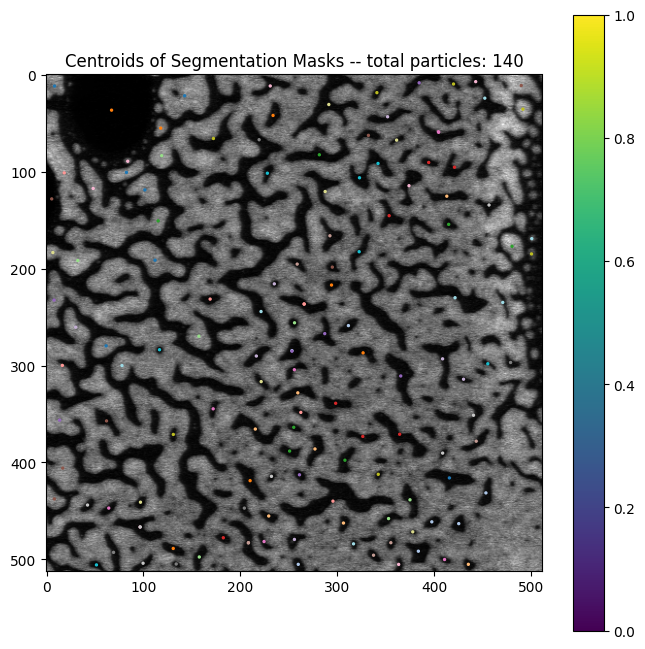

Positions array shape: (1904, 3)


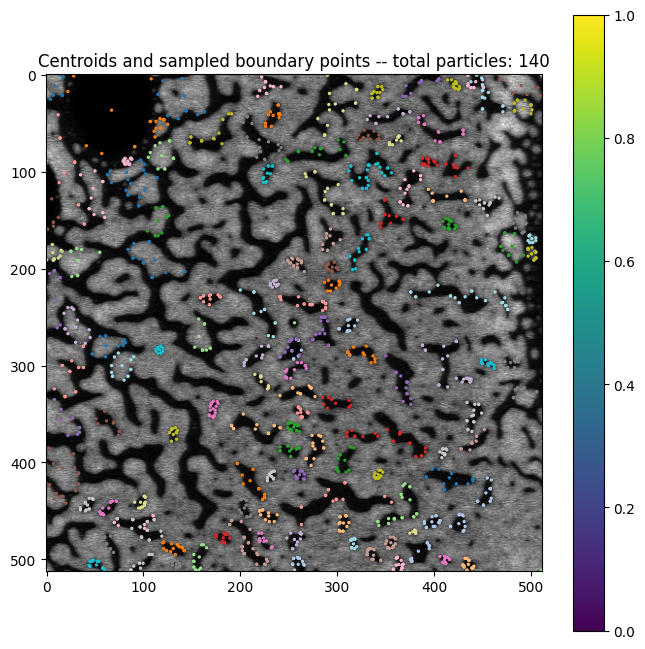

Processing complete!
20251008_115224


In [12]:
## run the segmentaiotn on haadf to get particles
from datetime import datetime
print( datetime.now().strftime("%Y%m%d_%H%M%S"))
all_particle_keys, each_particle_position = run_sam(haadf_np_array, out_path)
print( datetime.now().strftime("%Y%m%d_%H%M%S"))



In [ ]:
# filter particles based on need

## 1e. Get dummy edx at center of overview HAADF

In [13]:
import xmltodict
import json
from autoscript_tem_microscope_client.structures import EdsAcquisitionSettings
from autoscript_tem_microscope_client.enumerations import  EdsDetectorType, ExposureTimeType


def get_channel_index(energy_keV: float, dispersion: float, offset: float) -> int:
    """Convert energy (keV) into spectrum channel index."""
    return int(round((energy_keV - offset) / dispersion))



def get_dispersion_and_offset(spectrum):
    """
    Extract dispersion and offset from EDS spectrum metadata (xml).
    Returns (dispersion_keV_per_ch, offset_keV).
    """
    xml_string = spectrum.metadata.metadata_as_xml
    metadata = xmltodict.parse(xml_string)
    metadata = json.loads(json.dumps(metadata))

    detectors = metadata["Metadata"]["Detectors"]["AnalyticalDetector"]

    # If only one detector, wrap it into a list
    if isinstance(detectors, dict):
        detectors = [detectors]

    # Take the first detector (or filter by name if needed)
    det = detectors[0]
    dispersion = float(det.get("Dispersion", 0))
    offset = float(det.get("OffsetEnergy", 0))

    return dispersion, offset

def configure_acquisition(exposure_time=2):
    """Configure the EDS acquisition settings."""
    # mic_server is global variable intriduced in def run function
    eds_detector_name = microscope.detectors.eds_detectors[0]
    eds_detector = microscope.detectors.get_eds_detector(eds_detector_name)
    # Configure the acquisition
    global eds_settings
    eds_settings = EdsAcquisitionSettings()
    eds_settings.eds_detector = eds_detector_name
    eds_settings.dispersion = eds_detector.dispersions[-1]# 20 keV
    eds_settings.shaping_time = eds_detector.shaping_times[-1]
    eds_settings.exposure_time = exposure_time
    eds_settings.exposure_time_type = ExposureTimeType.LIVE_TIME
    return eds_settings

In [17]:
# position beam at center
microscope.optics.paused_scan_beam_position = (0.5,0.5) 

The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21


(0.0, 20.0)

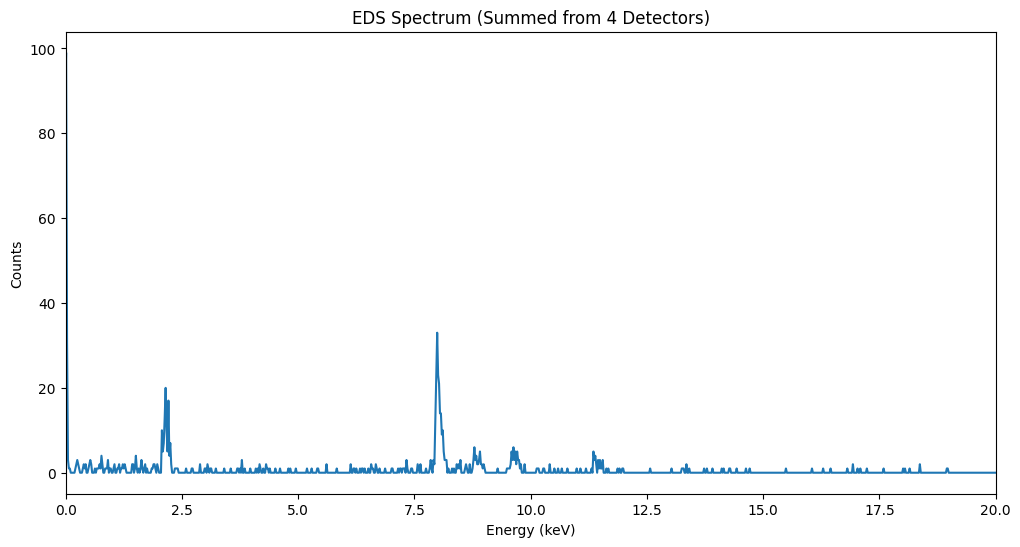

In [19]:
# Acquire the EDS spectrum
edx_exposure = 1 # in seconds
eds_settings = configure_acquisition(exposure_time=edx_exposure)

microscope.optics.unblank()
spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
microscope.optics.blank()


## plotting the spectrum
# Average spectrum data from 4 detectors
n_channels_per_detector = len(spectrum.data) // 4
summed_spectrum = np.zeros(n_channels_per_detector)

for i in range(4):
    start_idx = i * n_channels_per_detector
    end_idx = (i + 1) * n_channels_per_detector
    summed_spectrum += spectrum.data[start_idx:end_idx]

# Use summed spectrum for analysis
spectrum_data = summed_spectrum

# Plot spectrum using matplotlib instead of vision_toolkit
dispersion, offset = get_dispersion_and_offset(spectrum)
energy_axis = (np.arange(len(spectrum_data)) * dispersion + offset)/1000 # 1000 for Kev

plt.figure(figsize=(12, 6))
plt.plot(energy_axis, spectrum_data)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('EDS Spectrum (Summed from 4 Detectors)')
plt.xlim(0, 20)  # Focus on physically relevant energy range

## 1f. Lets caliberate the gun lens and increase current for better EDX signal
- Gun lens and screen current caliberation 
- credits:  Austin Houston

- Go to a hole and park the beam there. We want to see how beam current goes with gun lens



In [20]:
original_gun_lens = microscope.optics.monochromator.focus
print(original_gun_lens)

0.0


In [21]:
gun_lens_series = np.linspace(5, 100, 20)
current_series = []
import time

for val in gun_lens_series:
    # set lens value
    microscope.optics.monochromator.focus = val # original_gun_lens + val

    # wait
    time.sleep(1)

    # measure current
    screen_current = microscope.detectors.screen.measure_current()
    current_series.append(screen_current)

current_series = np.array(current_series) * 1e12

# reset to original
microscope.optics.monochromator.focus = original_gun_lens

Text(0, 0.5, 'Screen Current')

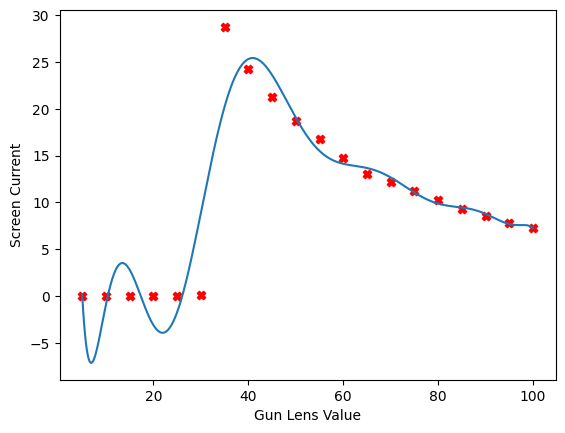

In [22]:
# fit a polynomial:
degree = 11
coeffs = np.polyfit(gun_lens_series, current_series, degree)
poly_func = np.poly1d(coeffs)

# generate fitted values
x_fit = np.linspace(min(gun_lens_series), max(gun_lens_series), 500)
y_fit = poly_func(x_fit)

# plot
plt.figure()
plt.plot(x_fit, y_fit)
plt.scatter(gun_lens_series, current_series, marker='X', c='r')

plt.xlabel('Gun Lens Value')
plt.ylabel('Screen Current')

In [23]:
def current_to_gun(desired_current, poly_func):
    # Define the new polynomial: poly_func(x) - y_target = 0
    adjusted_poly = poly_func - desired_current
    # Find the roots
    x_candidates = adjusted_poly.r
    # Filter for real solutions only (since roots might be complex)
    x_real = x_candidates[np.isreal(x_candidates)].real

    if len(x_real) == 1:
        return(x_real)
    else:
        return(np.max(x_real))

def set_current(desired_current):
    gun_value = current_to_gun(desired_current, poly_func)
    microscope.optics.monochromator.focus = gun_value

In [36]:
# Example
# we want screen current 60 pA for imaging
desired_current = 120 # pA
gun_val = current_to_gun(desired_current=desired_current, poly_func=poly_func)
microscope.optics.monochromator.focus = float(gun_val)

print(f'Set to: {desired_current} with gun value: {gun_val}')

Set to: 120 with gun value: [1.34208442]


/tmp/ipykernel_3180360/3867805210.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  microscope.optics.monochromator.focus = float(gun_val)


In [ ]:
# microscope.optics.paused_scan_beam_position = (0,0) # park the beam in the corner

The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21


(0.0, 20.0)

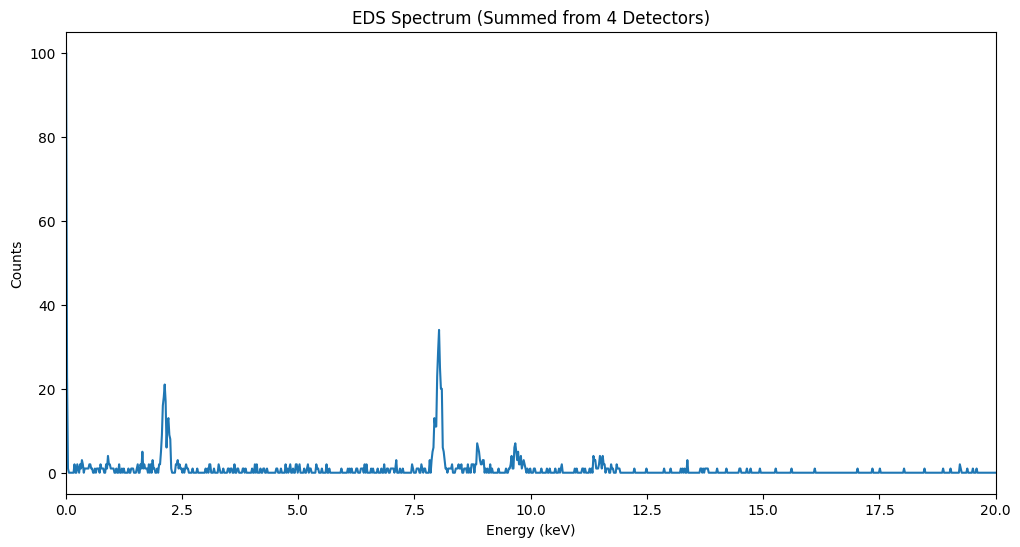

In [26]:
# edx again

# Acquire the EDS spectrum
edx_exposure = 1 # in seconds
eds_settings = configure_acquisition(exposure_time=edx_exposure)

microscope.optics.unblank()
spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
microscope.optics.blank()


## plotting the spectrum
# Average spectrum data from 4 detectors
n_channels_per_detector = len(spectrum.data) // 4
summed_spectrum = np.zeros(n_channels_per_detector)

for i in range(4):
    start_idx = i * n_channels_per_detector
    end_idx = (i + 1) * n_channels_per_detector
    summed_spectrum += spectrum.data[start_idx:end_idx]

# Use summed spectrum for analysis
spectrum_data = summed_spectrum

# Plot spectrum using matplotlib instead of vision_toolkit
dispersion, offset = get_dispersion_and_offset(spectrum)
energy_axis = (np.arange(len(spectrum_data)) * dispersion + offset)/1000 # 1000 for Kev

plt.figure(figsize=(12, 6))
plt.plot(energy_axis, spectrum_data)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('EDS Spectrum (Summed from 4 Detectors)')
plt.xlim(0, 20)  # Focus on physically relevant energy range

## 1g. Get EDX at center of particles

In [31]:

def acquire_and_plot_combined(image_data, particle_key):
    """Acquire EDS spectrum, CETA image, and plot all three components in a single figure."""
    # lets do just eels at boundary points
    print(f"edx at centers for particle{particle_key}")


    # Acquire the EDS spectrum
    microscope.optics.unblank()
    spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
    microscope.optics.blank()

    # Average spectrum data from 4 detectors
    n_channels_per_detector = len(spectrum.data) // 4
    summed_spectrum = np.zeros(n_channels_per_detector)

    for i in range(4):
        start_idx = i * n_channels_per_detector
        end_idx = (i + 1) * n_channels_per_detector
        summed_spectrum += spectrum.data[start_idx:end_idx]

    # Use summed spectrum for analysis
    spectrum_data = summed_spectrum

    # Plot spectrum using matplotlib instead of vision_toolkit
    dispersion, offset = get_dispersion_and_offset(spectrum)
    energy_axis = (np.arange(len(spectrum_data)) * dispersion + offset)/1000 # 1000 for Kev


    # Get the current beam position
    position = tf_acquisition.query_paused_beam_positon()
    x = position.x
    y = position.y
    formatted_position = f"({x:.2g}, {y:.2g})"


    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].imshow(image_data, cmap='gray')
    axs[0].set_title('Acquired Image')
    axs[0].set_axis_off()  # Hide axes for the image plot
    axs[0].scatter(x * image_data.shape[0], y * image_data.shape[1], c='r', s=100, marker='x', label=f"Position: {formatted_position}")

    # Plot the EDS spectrum
    axs[1].plot(energy_axis, spectrum_data)
    axs[1].set_title('EDS Spectrum (Summed from 4 Detectors)')
    axs[1].set_xlabel('Energy (keV)')
    axs[1].set_ylabel('Counts')
    axs[1].set_xlim(0, 20) 
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    pass


    
        
def run_acquisition_for_particle(image_data, particle_key, particle_dict):
    """Run the entire acquisition process for a given position."""
    position = list(particle_dict[particle_key]["centroid"])
    tf_acquisition.move_paused_beam(position[0], position[1])
    acquire_and_plot_combined(image_data, particle_key)
    pass

2025-10-08 11:56:32,300 - INFO - Set beam position: old Point(x=0.016055971, y=0.022350902)
2025-10-08 11:56:32,319 - INFO - UPDATED beam position: NewPoint(x=0.016055971, y=0.022350902)
edx at centers for particle1
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:34,404 - INFO - Request to query the paused beam postion
2025-10-08 11:56:34,408 - INFO - DONE: Query Paused beam position: which is at Point(x=0.016055971, y=0.022350902)


/tmp/ipykernel_3180360/1225739049.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


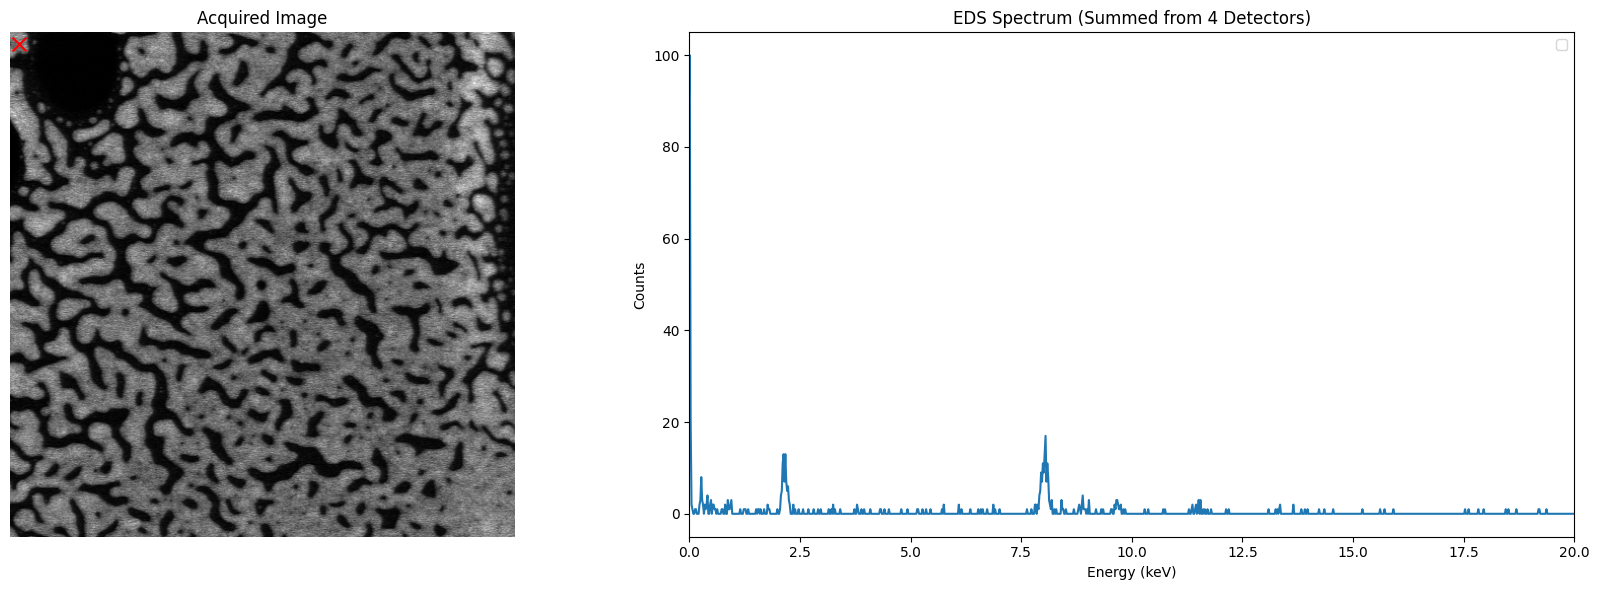

2025-10-08 11:56:34,880 - INFO - Set beam position: old Point(x=0.016055971, y=0.022350902)
2025-10-08 11:56:34,900 - INFO - UPDATED beam position: NewPoint(x=0.27835032, y=0.041932188)
edx at centers for particle2
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:36,743 - INFO - Request to query the paused beam postion
2025-10-08 11:56:36,747 - INFO - DONE: Query Paused beam position: which is at Point(x=0.27835032, y=0.041932188)


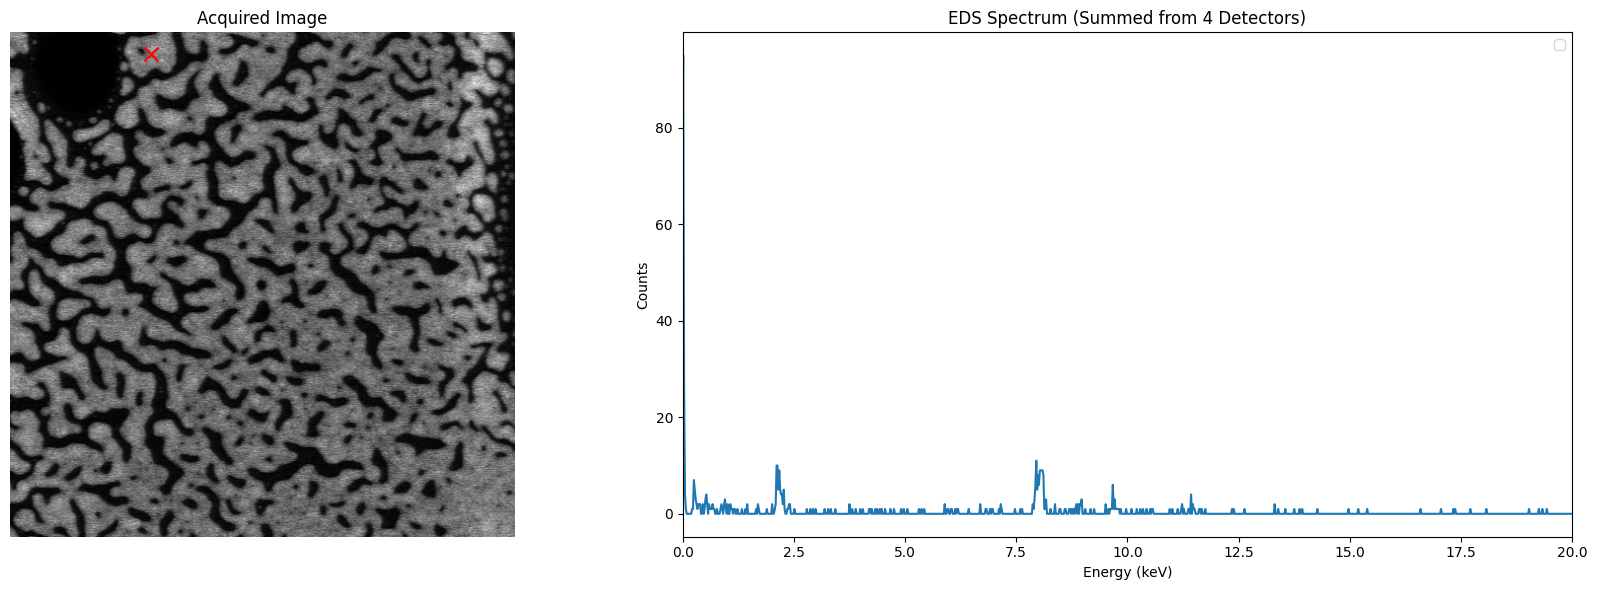

2025-10-08 11:56:37,329 - INFO - Set beam position: old Point(x=0.27835032, y=0.041932188)
2025-10-08 11:56:37,347 - INFO - UPDATED beam position: NewPoint(x=0.16097543, y=0.19641611)
edx at centers for particle3
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:39,195 - INFO - Request to query the paused beam postion
2025-10-08 11:56:39,199 - INFO - DONE: Query Paused beam position: which is at Point(x=0.16097543, y=0.19641611)


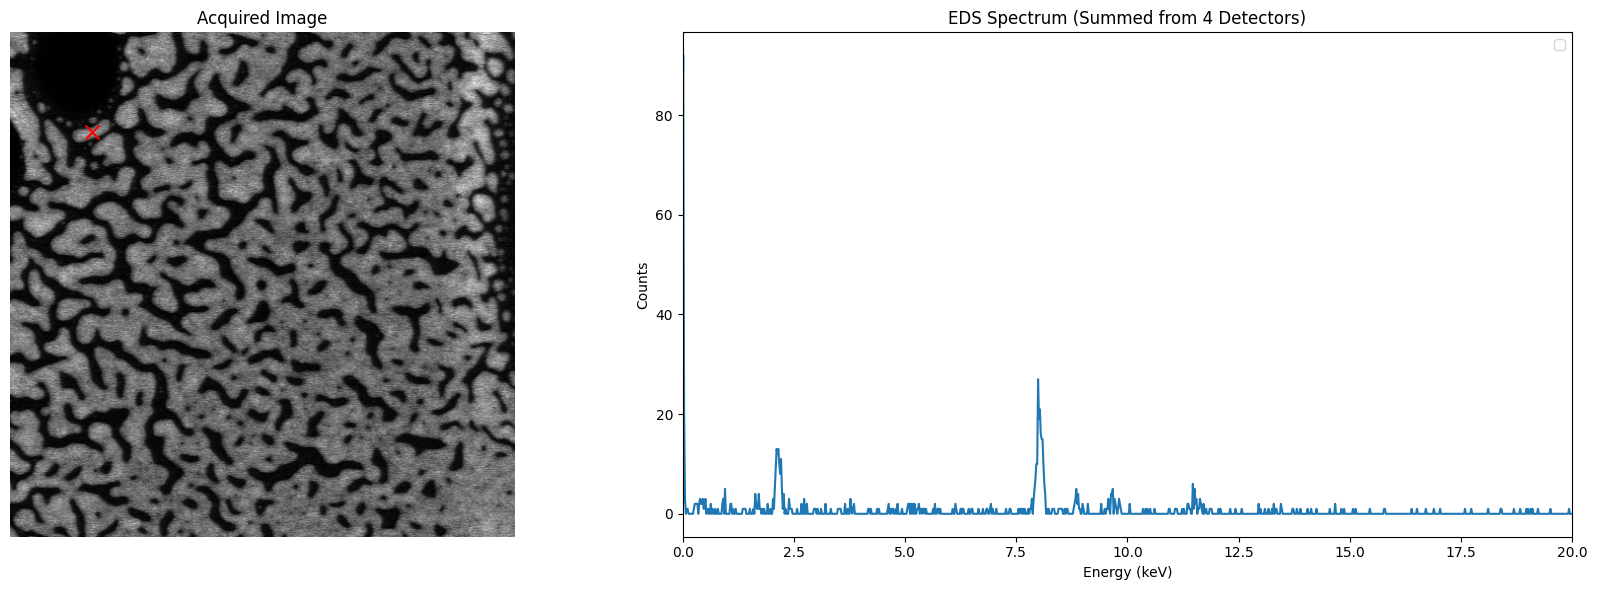

2025-10-08 11:56:39,498 - INFO - Set beam position: old Point(x=0.16097543, y=0.19641611)
2025-10-08 11:56:39,519 - INFO - UPDATED beam position: NewPoint(x=0.11994182, y=0.54610819)
edx at centers for particle4
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:41,447 - INFO - Request to query the paused beam postion
2025-10-08 11:56:41,451 - INFO - DONE: Query Paused beam position: which is at Point(x=0.11994182, y=0.54610819)


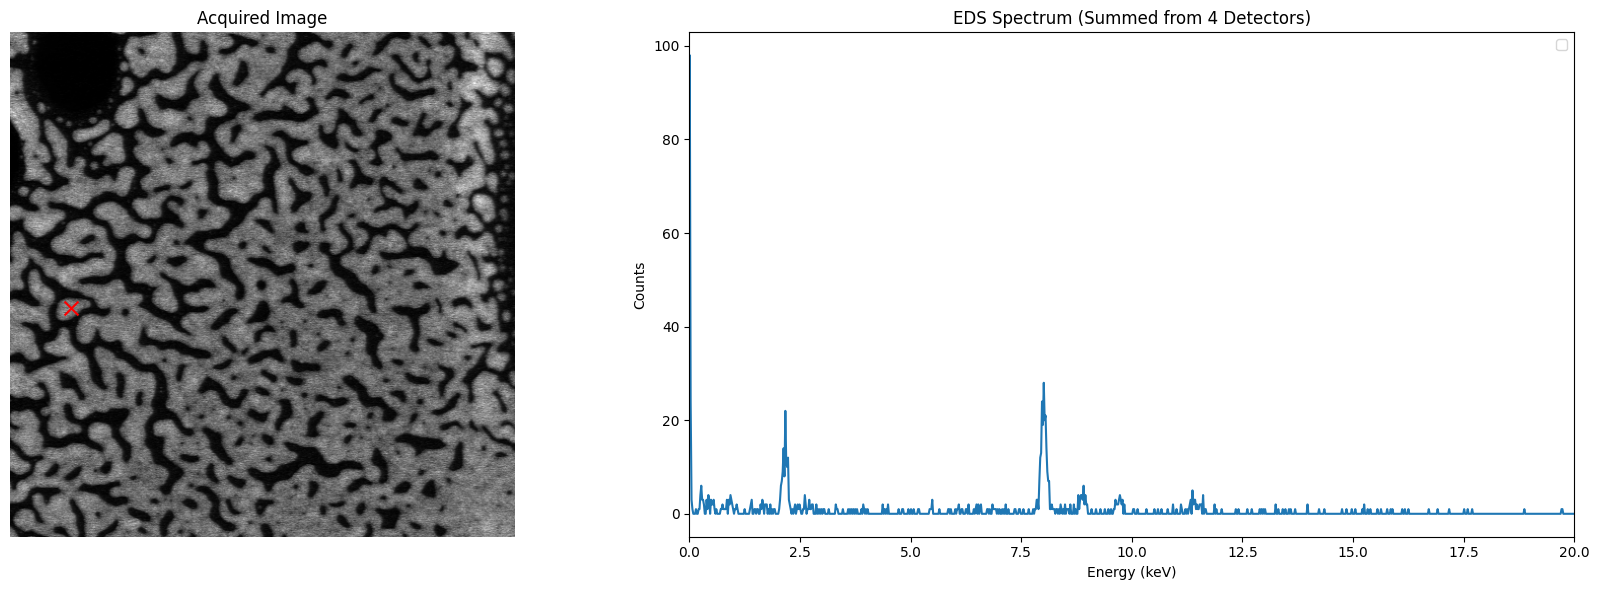

2025-10-08 11:56:41,746 - INFO - Set beam position: old Point(x=0.11994182, y=0.54610819)
2025-10-08 11:56:41,765 - INFO - UPDATED beam position: NewPoint(x=0.19817016, y=0.23170865)
edx at centers for particle5
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:43,579 - INFO - Request to query the paused beam postion
2025-10-08 11:56:43,582 - INFO - DONE: Query Paused beam position: which is at Point(x=0.19817016, y=0.23170865)


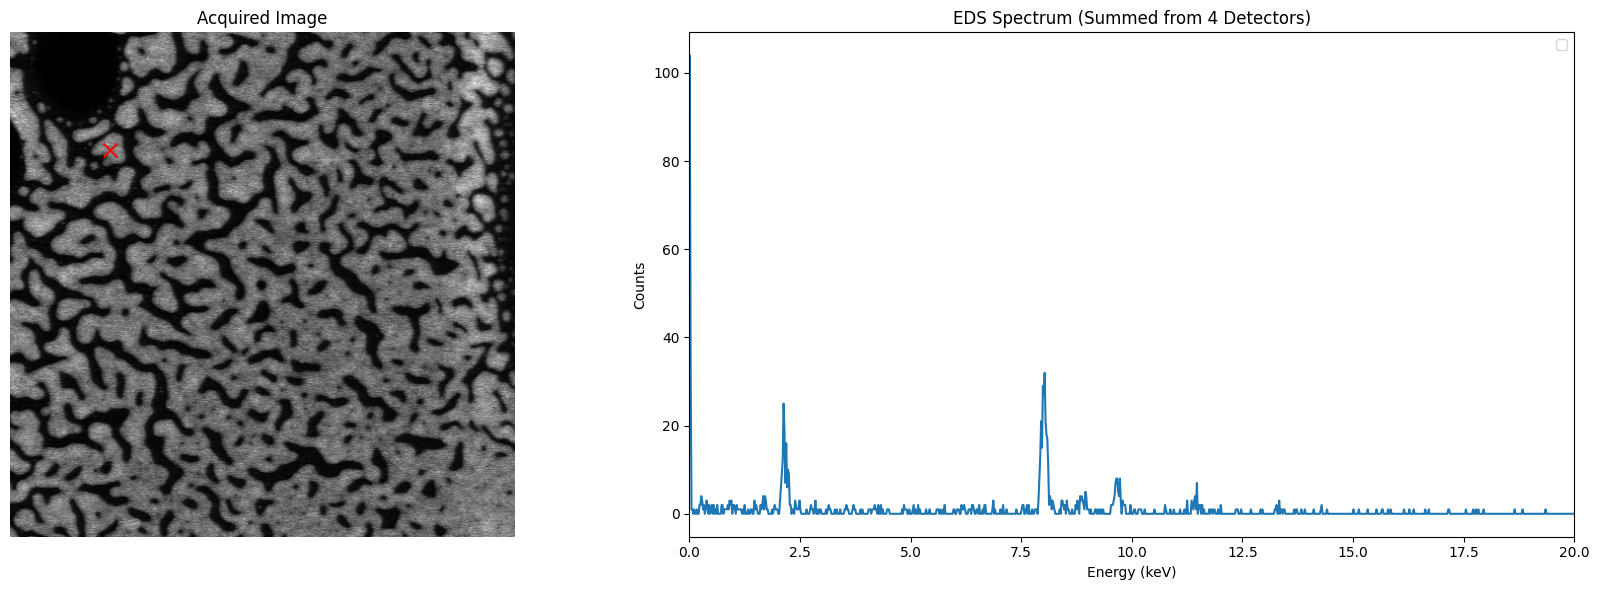

2025-10-08 11:56:43,876 - INFO - Set beam position: old Point(x=0.19817016, y=0.23170865)
2025-10-08 11:56:43,896 - INFO - UPDATED beam position: NewPoint(x=0.81209368, y=0.81235999)
edx at centers for particle6
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:45,695 - INFO - Request to query the paused beam postion
2025-10-08 11:56:45,698 - INFO - DONE: Query Paused beam position: which is at Point(x=0.81209368, y=0.81235999)


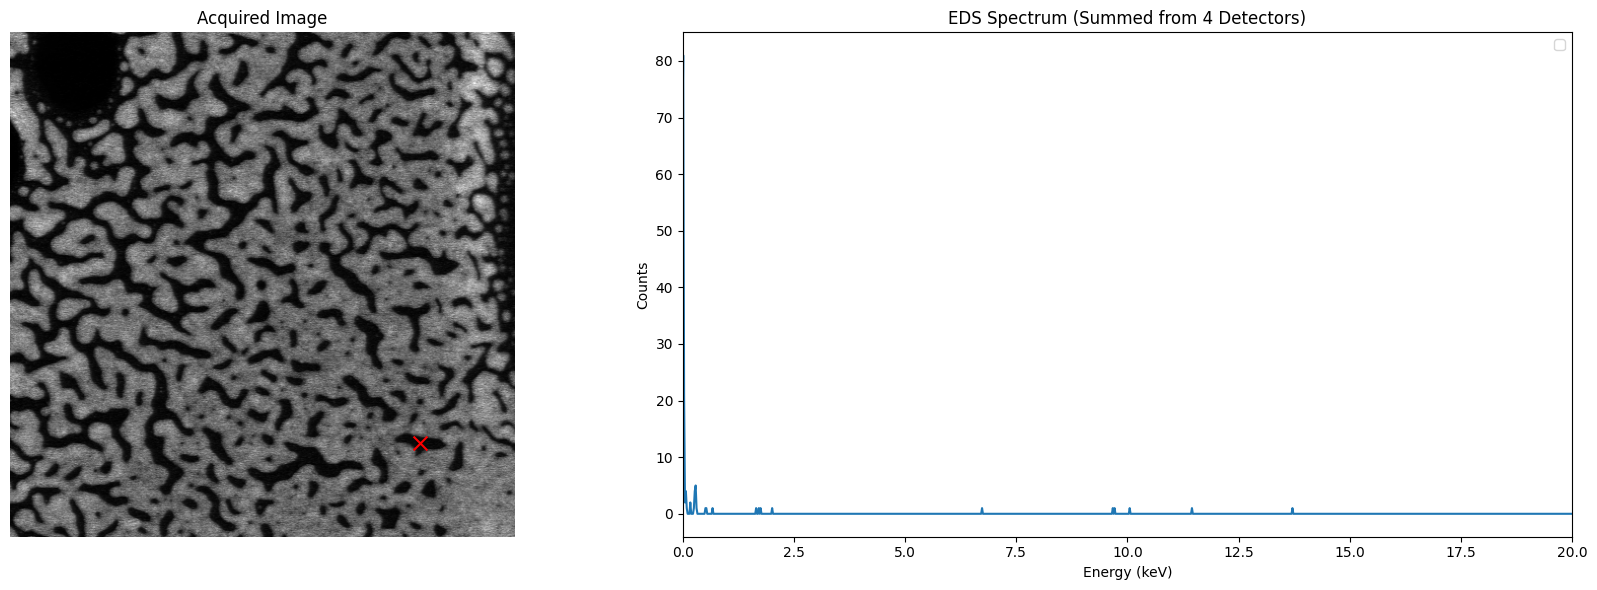

2025-10-08 11:56:46,011 - INFO - Set beam position: old Point(x=0.81209368, y=0.81235999)
2025-10-08 11:56:46,030 - INFO - UPDATED beam position: NewPoint(x=0.21859989, y=0.37336808)
edx at centers for particle7
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:47,913 - INFO - Request to query the paused beam postion
2025-10-08 11:56:47,916 - INFO - DONE: Query Paused beam position: which is at Point(x=0.21859989, y=0.37336808)


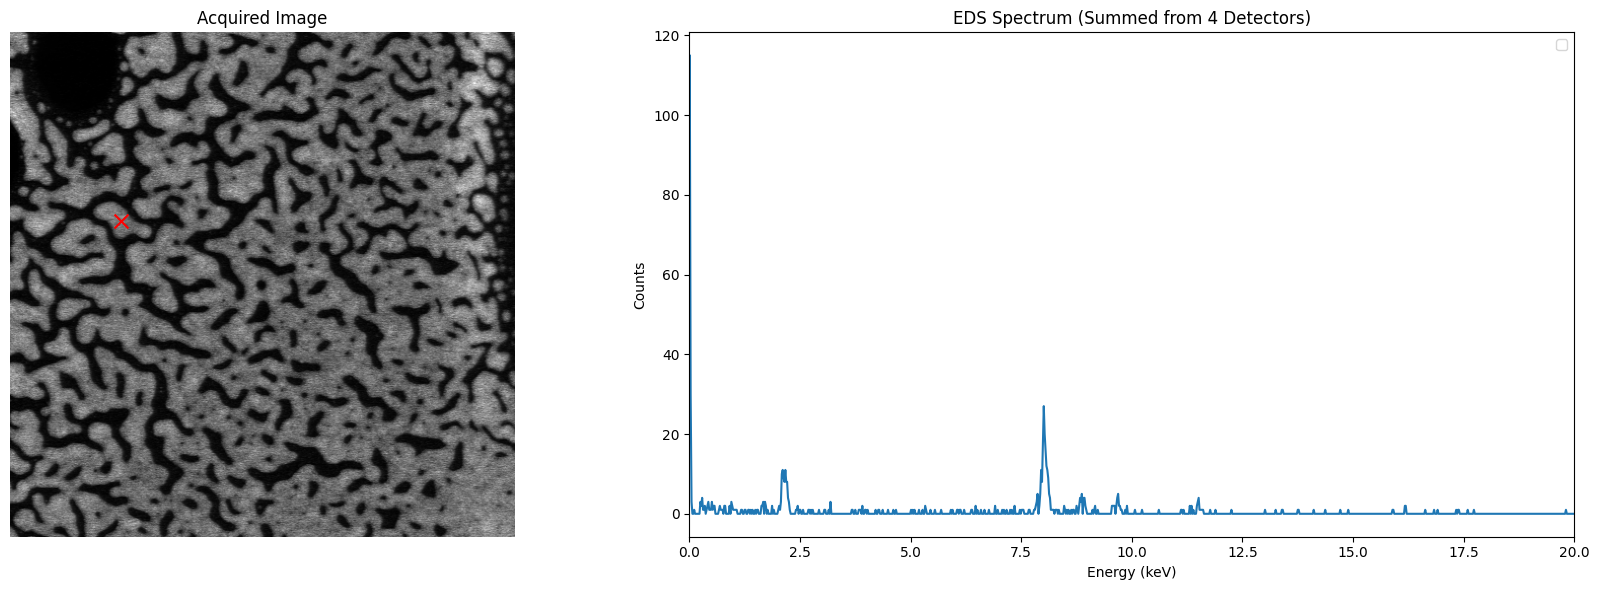

2025-10-08 11:56:48,220 - INFO - Set beam position: old Point(x=0.21859989, y=0.37336808)
2025-10-08 11:56:48,238 - INFO - UPDATED beam position: NewPoint(x=0.77666903, y=0.90091145)
edx at centers for particle8
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:50,190 - INFO - Request to query the paused beam postion
2025-10-08 11:56:50,194 - INFO - DONE: Query Paused beam position: which is at Point(x=0.77666903, y=0.90091145)


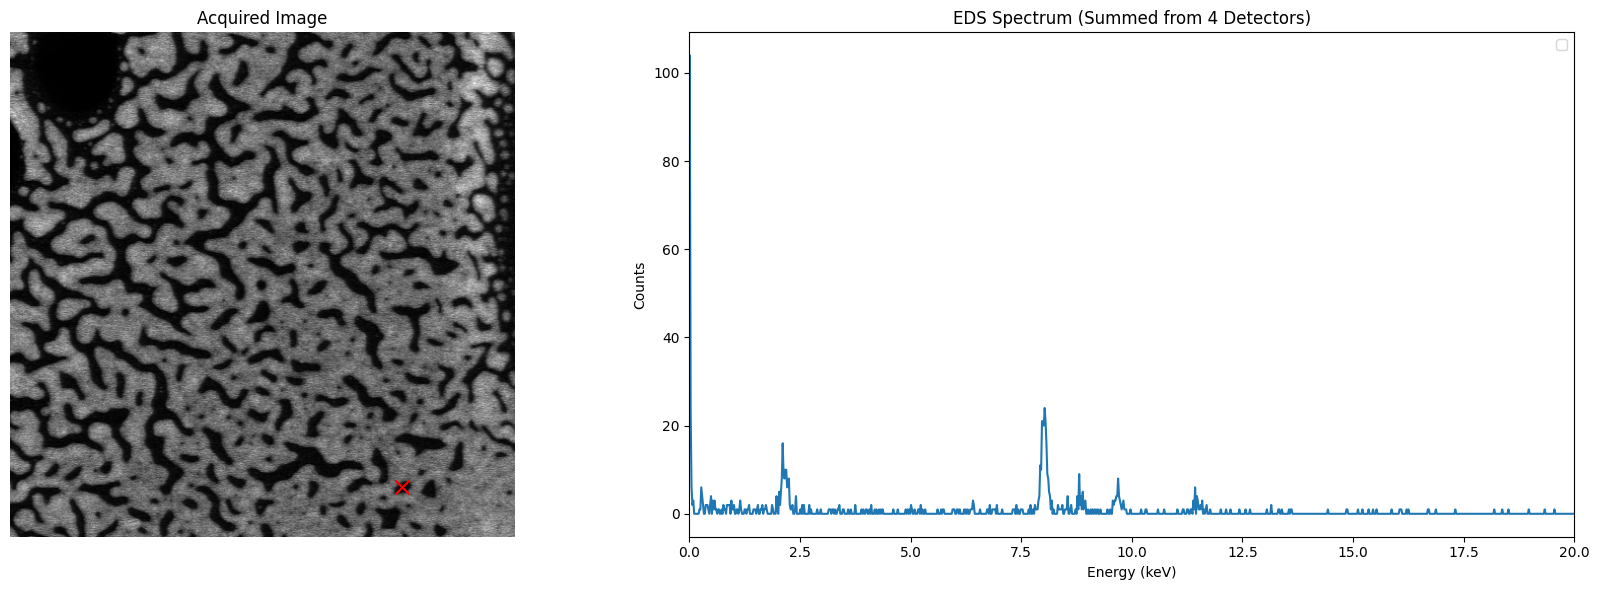

2025-10-08 11:56:50,493 - INFO - Set beam position: old Point(x=0.77666903, y=0.90091145)
2025-10-08 11:56:50,512 - INFO - UPDATED beam position: NewPoint(x=0.88574219, y=0.84259653)
edx at centers for particle9
The function 'unblank' is deprecated and will be removed in version 1.21
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:56:52,294 - INFO - Request to query the paused beam postion
2025-10-08 11:56:52,297 - INFO - DONE: Query Paused beam position: which is at Point(x=0.88574219, y=0.84259653)


KeyboardInterrupt: 

In [32]:
for particle_key in all_particle_keys:
    run_acquisition_for_particle(haadf_np_array, particle_key, each_particle_position)

## 1h. Get diffraction at the particle centres-- Please lower exposure on ceta and the current

In [33]:
# Example
# we want screen current 60 pA for imaging
desired_current = 10 # pA
gun_val = current_to_gun(desired_current=desired_current, poly_func=poly_func)
microscope.optics.monochromator.focus = float(gun_val)

print(f'Set to: {desired_current} with gun value: {gun_val}')

Set to: 10 with gun value: 79.15883128791127


In [34]:


def acquire_and_plot_combined(image_data, particle_key, ceta_exposure, ceta_resolution):
    """Acquire EDS spectrum, CETA image, and plot all three components in a single figure."""
    
    
    # lets do just eels at boundary points
    print(f"cbed at centres for particle{particle_key}")
    wait_sec = 2
    # print(f"ceta-wait insert{wait_sec} sec")
    # time.sleep(wait_sec)
    ceta_cp_array, ceta_tiff_name = tf_acquisition.acquire_ceta_or_flucam(exposure=ceta_exposure, resolution=ceta_resolution, camera="ceta")
    tiff_to_png(ceta_tiff_name)
    

    # clip the bright spots
    shifted_data = ceta_cp_array
    p99 = np.percentile(shifted_data.ravel(), 99)
    clipped_data = np.clip(shifted_data, 0, p99)
    clipped_data -= clipped_data.min()
    clipped_data /= clipped_data.max()
    norm_data = clipped_data
    # power law 2nd time through
    gamma = 1
    norm_data = norm_data ** gamma
    edge_crop = 256
    norm_data = norm_data[edge_crop:-edge_crop, edge_crop:-edge_crop]
    
    
    # Get the current beam position
    position = tf_acquisition.query_paused_beam_positon()
    x = position.x
    y = position.y
    formatted_position = f"({x:.2g}, {y:.2g})"

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Plot the acquired image data
    axs[0].imshow(image_data, cmap='gray')
    axs[0].set_title('Acquired Image')
    axs[0].set_axis_off()  # Hide axes for the image plot
    axs[0].scatter(x * image_data.shape[0], y * image_data.shape[1], c='r', s=100, marker='x', label=f"Position: {formatted_position}")
    axs[1].imshow((norm_data), cmap='gray')  # Using log contrast
    # axs[1].imshow(np.log(center_quarter + 1), cmap='gray')  # Using log contrast
    axs[1].set_title(f'Acquired CETA Image at Position: {formatted_position}')
    axs[1].set_axis_off()  # Hide axes for the image plot


    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    pass



def run_acquisition_for_particle(image_data, particle_key, particle_dict, ceta_exposure):
    """Run the entire acquisition process for a given position."""
    position = list(particle_dict[particle_key]["centroid"])
    tf_acquisition.move_paused_beam(position[0], position[1])
    acquire_and_plot_combined(image_data, particle_key, ceta_exposure)




    

2025-10-08 11:59:08,795 - INFO - Set beam position: old Point(x=0.88574219, y=0.84259653)
2025-10-08 11:59:08,818 - INFO - UPDATED beam position: NewPoint(x=0.016055971, y=0.022350902)
cbed at centres for particle1
2025-10-08 11:59:14,713 - INFO - Acquiring ceta image.
2025-10-08 11:59:14,715 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-08 11:59:14,719 - INFO - DONE -- beam UNblanking
2025-10-08 11:59:33,086 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:59:33,102 - INFO - DONE -- beam blanking
2025-10-08 11:59:38,689 - INFO - Saved ceta image with metadata to ceta_image_20251008_115914.tiff


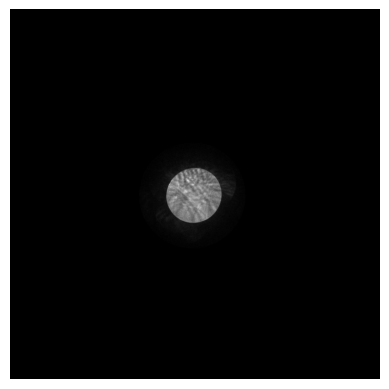

2025-10-08 11:59:39,029 - INFO - Request to query the paused beam postion
2025-10-08 11:59:39,034 - INFO - DONE: Query Paused beam position: which is at Point(x=0.016055971, y=0.022350902)


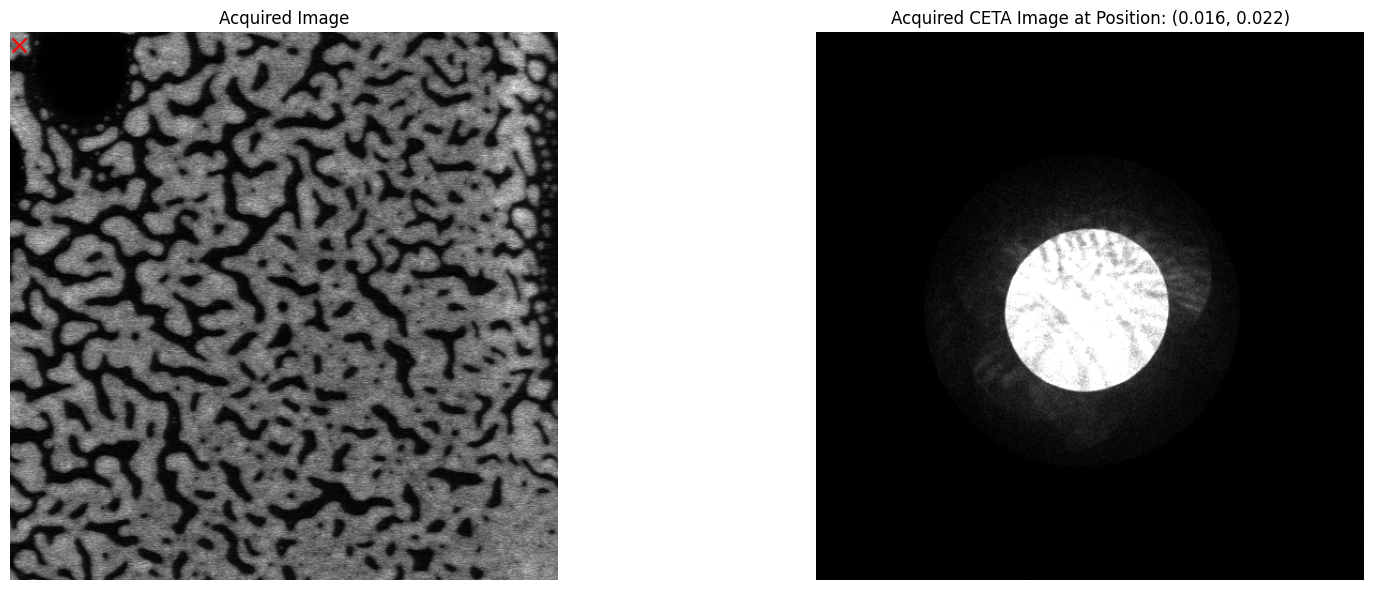

2025-10-08 11:59:39,393 - INFO - Set beam position: old Point(x=0.016055971, y=0.022350902)
2025-10-08 11:59:39,413 - INFO - UPDATED beam position: NewPoint(x=0.27835032, y=0.041932188)
cbed at centres for particle2
2025-10-08 11:59:45,655 - INFO - Acquiring ceta image.
2025-10-08 11:59:45,657 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-08 11:59:45,782 - INFO - DONE -- beam UNblanking
2025-10-08 11:59:47,075 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 11:59:47,092 - INFO - DONE -- beam blanking
2025-10-08 11:59:52,686 - INFO - Saved ceta image with metadata to ceta_image_20251008_115945.tiff


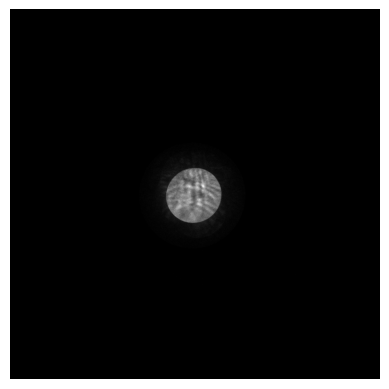

2025-10-08 11:59:52,840 - INFO - Request to query the paused beam postion
2025-10-08 11:59:52,845 - INFO - DONE: Query Paused beam position: which is at Point(x=0.27835032, y=0.041932188)


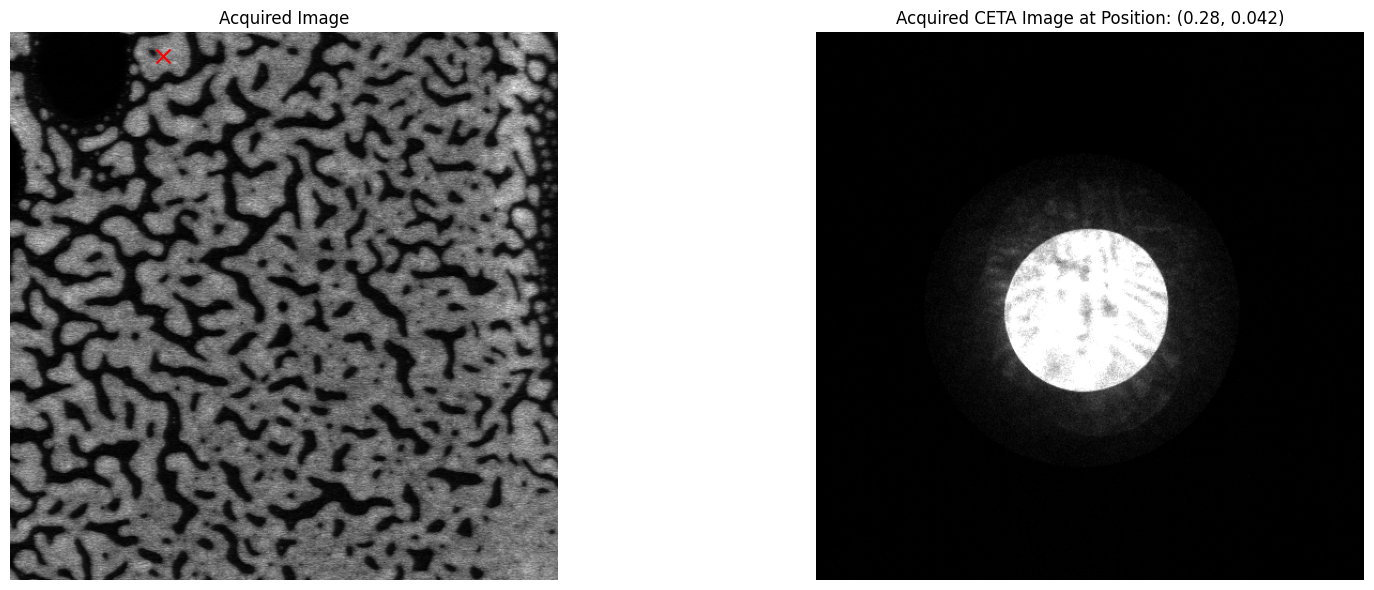

2025-10-08 11:59:53,505 - INFO - Set beam position: old Point(x=0.27835032, y=0.041932188)
2025-10-08 11:59:53,524 - INFO - UPDATED beam position: NewPoint(x=0.16097543, y=0.19641611)
cbed at centres for particle3
2025-10-08 11:59:59,655 - INFO - Acquiring ceta image.
2025-10-08 11:59:59,657 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-08 11:59:59,781 - INFO - DONE -- beam UNblanking
2025-10-08 12:00:01,065 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 12:00:01,081 - INFO - DONE -- beam blanking
2025-10-08 12:00:06,690 - INFO - Saved ceta image with metadata to ceta_image_20251008_115959.tiff


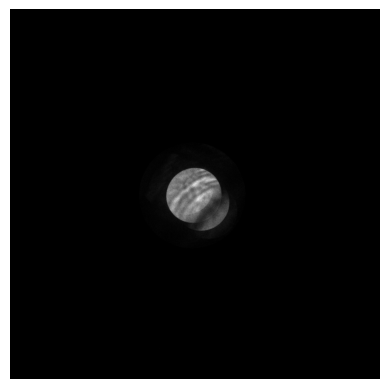

2025-10-08 12:00:06,845 - INFO - Request to query the paused beam postion
2025-10-08 12:00:06,850 - INFO - DONE: Query Paused beam position: which is at Point(x=0.16097543, y=0.19641611)


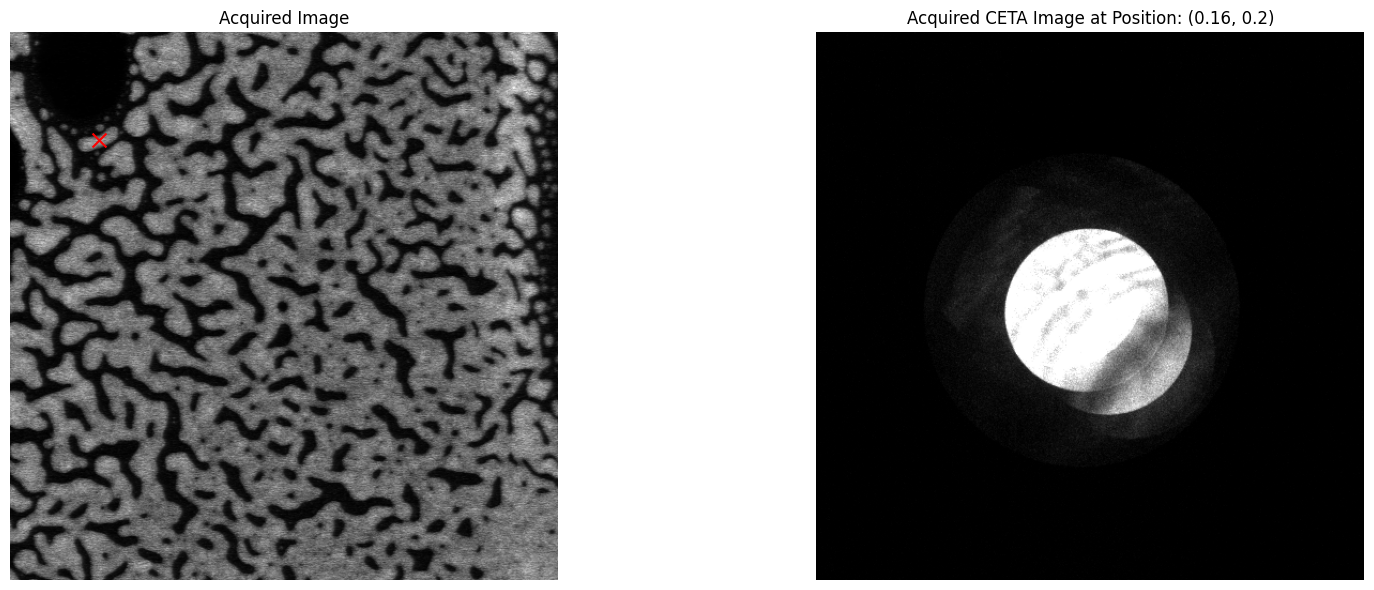

2025-10-08 12:00:07,197 - INFO - Set beam position: old Point(x=0.16097543, y=0.19641611)
2025-10-08 12:00:07,215 - INFO - UPDATED beam position: NewPoint(x=0.11994182, y=0.54610819)
cbed at centres for particle4
2025-10-08 12:00:13,656 - INFO - Acquiring ceta image.
2025-10-08 12:00:13,658 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-08 12:00:13,775 - INFO - DONE -- beam UNblanking
2025-10-08 12:00:15,080 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-08 12:00:15,096 - INFO - DONE -- beam blanking
2025-10-08 12:00:20,687 - INFO - Saved ceta image with metadata to ceta_image_20251008_120013.tiff


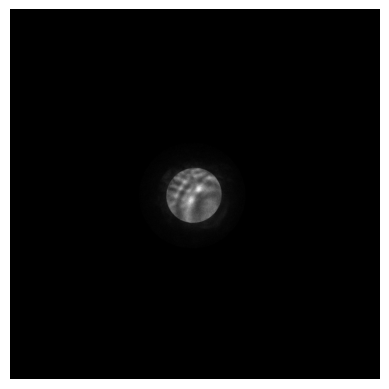

2025-10-08 12:00:20,833 - INFO - Request to query the paused beam postion
2025-10-08 12:00:20,837 - INFO - DONE: Query Paused beam position: which is at Point(x=0.11994182, y=0.54610819)


KeyboardInterrupt: 

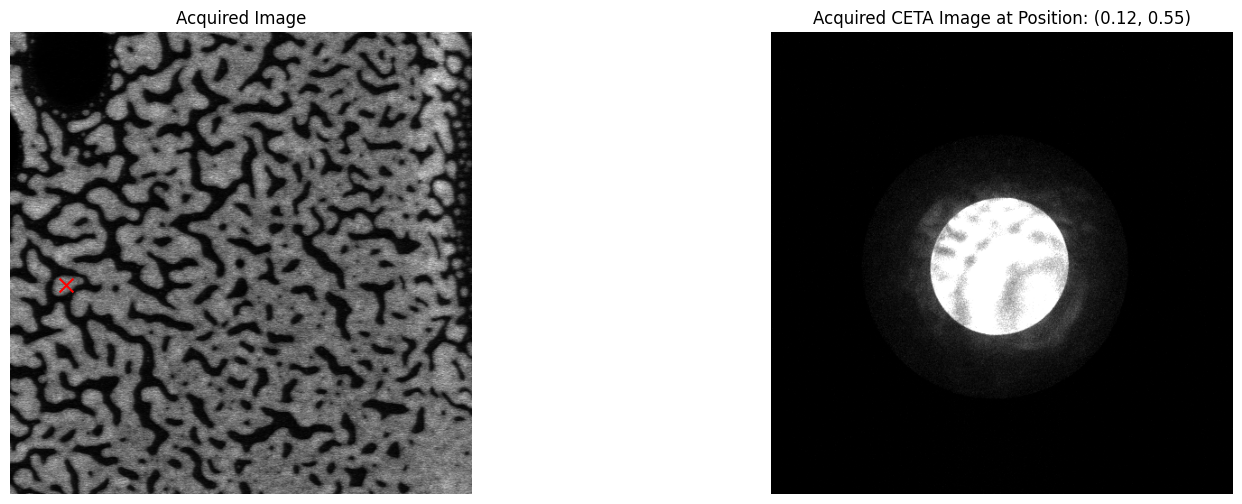

In [35]:

ceta_exposure = 0.1 # seconds
ceta_resolution = 1024
# Save the dictionary to disk

for particle_key in all_particle_keys:
    run_acquisition_for_particle(haadf_np_array,particle_key, each_particle_position, ceta_exposure, ceta_resolution)# 25 seconds per reading: --> 1min 35 seconds for 4 points

##